In [1]:

import numpy as np
from utils.modelUtils import load_sam, load_sam_inferer
#from classes.SAMClass import SAMWrapper, SAMInferer
from classes.SAMClass import SAMWrapper, SAMInferer
from utils.base_classes import Points
import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

sam_inferer = SAMInferer(checkpoint_path, 'cuda')

# Load in image, label, prompt
# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path)

img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 2)


/home/t722s/anaconda3/envs/foundationModels/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n_clicks = 5
point_prompt = prUt.get_pos_clicks2D_row_major(gt, n_clicks, seed = seed)
segmentation = sam_inferer.predict(img, point_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


0.11034912643757769

In [3]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)
segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 21/21 [00:00<00:00, 171.28it/s]


0.8690242677507083

In [13]:
# Experiment: get 3d bbox and slice it to feed it in 2d axially
box_prompt = prUt.get_bbox3d_sliced(gt)

segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

0.7636174284813798

In [12]:
# Experiment: line interpolation
n_slices = 5
interpolation = 'linear'
simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n_slices)
coords = prUt.interpolate_points(simulated_clicks, kind = interpolation).astype(int)

def line_interpolation(gt, n_slices):
    simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n_slices)
    coords = prUt.interpolate_points(simulated_clicks, kind = interpolation).astype(int)
    point_prompt = Points({'coords': coords, 'labels': [1]*len(coords)})
    return(point_prompt)


segmentation = sam_inferer.predict(img, point_prompt)
anUt.compute_dice(segmentation, gt)

0.912622782583199

In [2]:
# Experiment: box interpolation
n_boxes = 5

seed_boxes = prUt.get_seed_boxes(gt, n_boxes)
box_prompt = prUt.box_interpolation(seed_boxes)
segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 45/45 [00:01<00:00, 22.83it/s]


0.9463972842750766

In [14]:
# Experiment: Point propagation

seed = 11121
n_clicks = 5

# Get seed prompt and bounds
seed_point = prUt.get_seed_point(gt, n_clicks)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation = prUt.point_propagation(sam_inferer, img, seed_point, slices_to_infer, seed, n_clicks)
print(anUt.compute_dice(gt,segmentation))


Propagating up: 100%|██████████| 22/22 [00:10<00:00,  2.04it/s]


0.7984751851037314


In [2]:
# Experiment: Box propagation

seed_box = prUt.get_seed_box(gt)
slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0]

segmentation = prUt.box_propagation(sam_inferer, img, seed_box, slices_to_infer)

print(anUt.compute_dice(gt,segmentation))

Propagating up:  69%|██████▉   | 33/48 [00:01<00:00, 23.46it/s]/home/t722s/Desktop/UniversalModels/Project/UniversalInterface/utils/promptUtils.py:501: UserWarning: 
Terminate early: no fg generated
  warnings.warn('\nTerminate early: no fg generated')
Propagating up:  71%|███████   | 34/48 [00:01<00:00, 22.79it/s]


0.4829657225423463


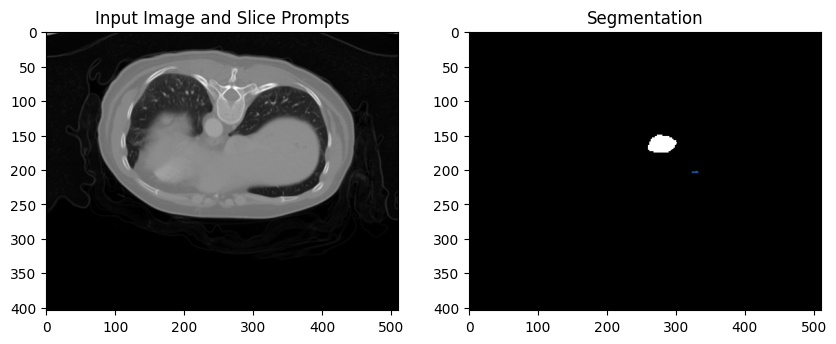

0.0

In [21]:
# Slice visualisation (points):
slice_idx = 183
anUt.show_seg_row_major(slice_idx, img, gt, segmentation) #, pts_prompt= pts_prompt, box_prompt = box_prompt)